# NB04: Corrected Metal Atlas — Conservation After Removing Shared-Stress Genes

**Goal**: Test H1c — re-analyze the Metal Fitness Atlas core enrichment after removing
genes that are shared with NaCl stress. Does the 87.4% core (OR=2.08) finding survive
when we restrict to metal-specific genes only?

**Inputs**:
- `data/gene_classification_shared_vs_metal.csv` — gene classifications from NB03
- `projects/conservation_vs_fitness/data/fb_pangenome_link.tsv` — conservation data
- `projects/metal_fitness_atlas/data/metal_conservation_stats.csv` — original atlas stats

**Outputs**:
- `data/corrected_metal_conservation.csv` — conservation stats for metal-specific genes
- `figures/atlas_original_vs_corrected.png` — comparison visualization

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pathlib import Path

PROJ = Path('..')
REPO = PROJ / '..'
DATA_OUT = PROJ / 'data'
FIG_OUT = PROJ / 'figures'
CONSERV = REPO / 'conservation_vs_fitness' / 'data'
METAL_ATLAS = REPO / 'metal_fitness_atlas' / 'data'

## 1. Load Gene Classifications and Conservation Data

In [2]:
# Gene classifications
classified = pd.read_csv(DATA_OUT / 'gene_classification_shared_vs_metal.csv')

# FB-pangenome link (conservation status)
link = pd.read_csv(CONSERV / 'fb_pangenome_link.tsv', sep='\t')

# Organism mapping (FB orgId -> pangenome clade)
org_map = pd.read_csv(CONSERV / 'organism_mapping.tsv', sep='\t')

print(f'Classified genes: {len(classified)}')
print(f'FB-pangenome links: {len(link)}')
print(f'Organism mappings: {len(org_map)}')

# Merge conservation status
# The link table has orgId, locusId, gene_cluster_id, is_core, is_auxiliary, is_singleton
link_cols = ['orgId', 'locusId']
if 'is_core' in link.columns:
    link_cols += ['is_core', 'is_auxiliary', 'is_singleton']
elif 'isCore' in link.columns:
    link_cols += ['isCore', 'isAccessory', 'isSingleton']
    link = link.rename(columns={'isCore': 'is_core', 'isAccessory': 'is_auxiliary', 'isSingleton': 'is_singleton'})
    link_cols = ['orgId', 'locusId', 'is_core', 'is_auxiliary', 'is_singleton']

print(f'Link columns: {link.columns.tolist()}')

Classified genes: 10821
FB-pangenome links: 177863
Organism mappings: 498
Link columns: ['orgId', 'locusId', 'gene_cluster_id', 'gtdb_species_clade_id', 'pident', 'evalue', 'bitscore', 'is_core', 'is_auxiliary', 'is_singleton']


In [3]:
# Merge classified genes with conservation status
merged = classified.merge(
    link[['orgId', 'locusId', 'is_core']].drop_duplicates(['orgId', 'locusId']),
    on=['orgId', 'locusId'],
    how='inner'
)

# Ensure is_core is numeric
merged['is_core'] = pd.to_numeric(merged['is_core'], errors='coerce')

print(f'Classified genes with conservation data: {len(merged)}')
print(f'Organisms: {merged["orgId"].nunique()}')
print()

# Overall conservation by class
for cls in ['shared_stress', 'metal_specific']:
    sub = merged[merged['gene_class'] == cls]
    core_frac = sub['is_core'].mean()
    print(f'{cls}: {core_frac:.3f} core ({len(sub)} genes)')

Classified genes with conservation data: 8924
Organisms: 17

shared_stress: 0.882 core (3444 genes)
metal_specific: 0.873 core (5480 genes)


## 2. Corrected Conservation Analysis

In [4]:
# Get baseline core fraction per organism (all genes with conservation data)
baseline = link.groupby('orgId')['is_core'].agg(['mean', 'count']).reset_index()
baseline.columns = ['orgId', 'baseline_core_frac', 'n_total']

# Per-metal conservation: original (all metal genes) vs corrected (metal-specific only)
results = []

for metal in sorted(merged['metal_element'].unique()):
    # Original: all metal-important genes
    all_metal = merged[merged['metal_element'] == metal]
    original_core = all_metal['is_core'].mean()
    n_original = len(all_metal)
    
    # Corrected: metal-specific only
    specific = merged[
        (merged['metal_element'] == metal) & (merged['gene_class'] == 'metal_specific')
    ]
    corrected_core = specific['is_core'].mean() if len(specific) > 0 else np.nan
    n_corrected = len(specific)
    
    # Shared-stress genes
    shared = merged[
        (merged['metal_element'] == metal) & (merged['gene_class'] == 'shared_stress')
    ]
    shared_core = shared['is_core'].mean() if len(shared) > 0 else np.nan
    n_shared = len(shared)
    
    # Baseline for these organisms
    metal_orgs = all_metal['orgId'].unique()
    base_sub = baseline[baseline['orgId'].isin(metal_orgs)]
    mean_baseline = (base_sub['baseline_core_frac'] * base_sub['n_total']).sum() / base_sub['n_total'].sum()
    
    results.append({
        'metal_element': metal,
        'n_orgs': all_metal['orgId'].nunique(),
        'n_original': n_original,
        'original_core_frac': original_core,
        'n_corrected': n_corrected,
        'corrected_core_frac': corrected_core,
        'n_shared': n_shared,
        'shared_core_frac': shared_core,
        'baseline_core_frac': mean_baseline,
        'original_delta': original_core - mean_baseline,
        'corrected_delta': corrected_core - mean_baseline if pd.notna(corrected_core) else np.nan
    })

results_df = pd.DataFrame(results).sort_values('original_delta', ascending=False)

print('Per-metal conservation: Original vs Corrected')
print('=' * 100)
display_cols = ['metal_element', 'n_orgs', 'n_original', 'original_core_frac', 
                'n_corrected', 'corrected_core_frac', 'baseline_core_frac',
                'original_delta', 'corrected_delta']
print(results_df[display_cols].to_string(index=False, float_format='%.3f'))

Per-metal conservation: Original vs Corrected
metal_element  n_orgs  n_original  original_core_frac  n_corrected  corrected_core_frac  baseline_core_frac  original_delta  corrected_delta
    Manganese       1          30               1.000           13                1.000               0.818           0.182            0.182
         Zinc      11        1364               0.895          719                0.865               0.750           0.145            0.115
   Molybdenum       1         302               0.950          274                0.964               0.818           0.132            0.145
     Tungsten       1         303               0.947          270                0.952               0.818           0.129            0.134
      Mercury       1         106               0.934           82                0.951               0.818           0.116            0.133
     Selenium       1         134               0.933           98                0.949               0.818 

In [5]:
# Overall statistics
all_metal_genes = merged
metal_specific_genes = merged[merged['gene_class'] == 'metal_specific']
shared_genes = merged[merged['gene_class'] == 'shared_stress']

# Weighted baseline
all_orgs = merged['orgId'].unique()
base_all = baseline[baseline['orgId'].isin(all_orgs)]
overall_baseline = (base_all['baseline_core_frac'] * base_all['n_total']).sum() / base_all['n_total'].sum()

print('=== OVERALL STATISTICS ===')
print(f'Baseline core fraction: {overall_baseline:.3f}')
print(f'All metal genes: {all_metal_genes["is_core"].mean():.3f} (n={len(all_metal_genes)}, delta=+{all_metal_genes["is_core"].mean() - overall_baseline:.3f})')
print(f'Metal-specific genes: {metal_specific_genes["is_core"].mean():.3f} (n={len(metal_specific_genes)}, delta=+{metal_specific_genes["is_core"].mean() - overall_baseline:.3f})')
print(f'Shared-stress genes: {shared_genes["is_core"].mean():.3f} (n={len(shared_genes)}, delta=+{shared_genes["is_core"].mean() - overall_baseline:.3f})')
print()

# Fisher exact: corrected metal-specific vs baseline
n_ms = len(metal_specific_genes)
n_ms_core = int(metal_specific_genes['is_core'].sum())
total_n = int(base_all['n_total'].sum())
total_core = int((base_all['baseline_core_frac'] * base_all['n_total']).sum())

# 2x2: [metal_specific_core, metal_specific_noncorec], [other_core, other_noncore]
a = n_ms_core
b = n_ms - n_ms_core
c = total_core - n_ms_core
d = (total_n - n_ms) - c
if d < 0:
    d = 0
or_val, p = stats.fisher_exact([[a, b], [c, d]])
print(f'Fisher exact (metal-specific vs baseline): OR={or_val:.2f}, p={p:.2e}')

=== OVERALL STATISTICS ===
Baseline core fraction: 0.797
All metal genes: 0.877 (n=8924, delta=+0.080)
Metal-specific genes: 0.873 (n=5480, delta=+0.076)
Shared-stress genes: 0.882 (n=3444, delta=+0.086)

Fisher exact (metal-specific vs baseline): OR=1.82, p=7.55e-53


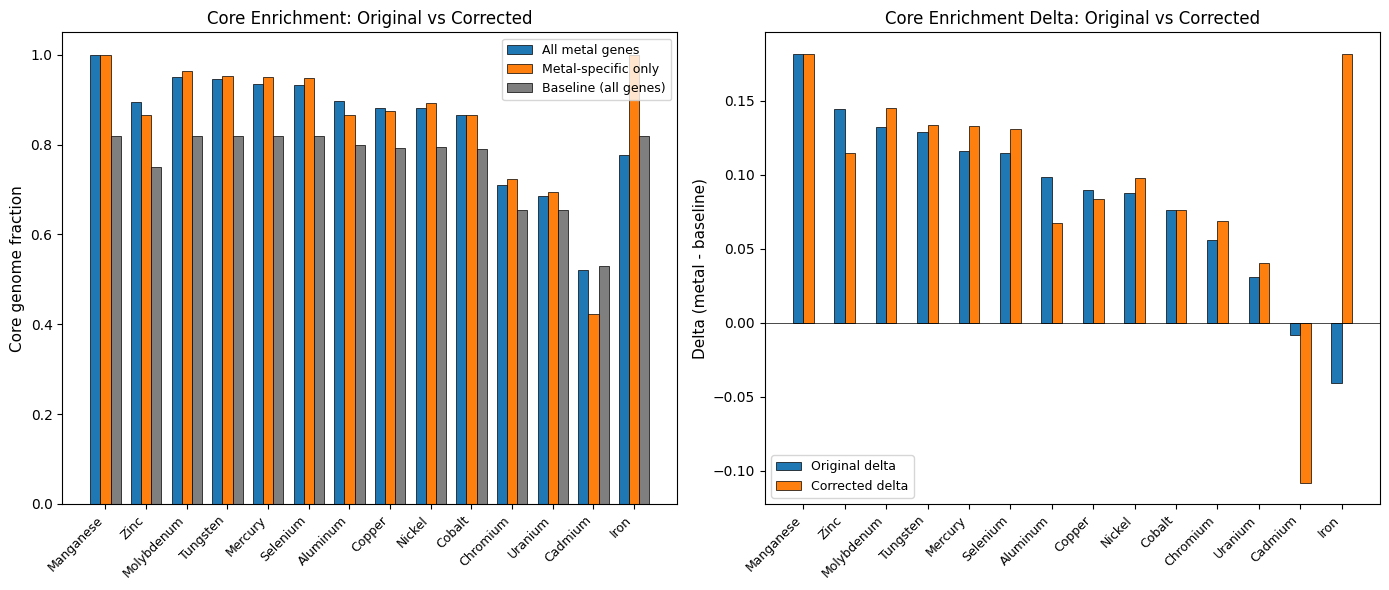

Saved to figures/atlas_original_vs_corrected.png


In [6]:
# Figure: Original vs Corrected conservation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel A: Per-metal comparison
ax = axes[0]
metals = results_df['metal_element'].values
x = np.arange(len(metals))
w = 0.25

ax.bar(x - w, results_df['original_core_frac'], w, label='All metal genes', color='#1f77b4', edgecolor='k', linewidth=0.5)
ax.bar(x, results_df['corrected_core_frac'], w, label='Metal-specific only', color='#ff7f0e', edgecolor='k', linewidth=0.5)
ax.bar(x + w, results_df['baseline_core_frac'], w, label='Baseline (all genes)', color='#7f7f7f', edgecolor='k', linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(metals, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Core genome fraction', fontsize=11)
ax.set_title('Core Enrichment: Original vs Corrected', fontsize=12)
ax.legend(fontsize=9)
ax.set_ylim(0, 1.05)

# Panel B: Delta comparison (bar chart)
ax = axes[1]
ax.bar(x - w/2, results_df['original_delta'], w, label='Original delta', color='#1f77b4', edgecolor='k', linewidth=0.5)
ax.bar(x + w/2, results_df['corrected_delta'], w, label='Corrected delta', color='#ff7f0e', edgecolor='k', linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(metals, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Delta (metal - baseline)', fontsize=11)
ax.set_title('Core Enrichment Delta: Original vs Corrected', fontsize=12)
ax.legend(fontsize=9)
ax.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
fig.savefig(FIG_OUT / 'atlas_original_vs_corrected.png', dpi=150, bbox_inches='tight')
plt.show()
print('Saved to figures/atlas_original_vs_corrected.png')

In [7]:
# Save
results_df.to_csv(DATA_OUT / 'corrected_metal_conservation.csv', index=False)
print(f'Saved corrected conservation stats for {len(results_df)} metals')

Saved corrected conservation stats for 14 metals


## Summary

After removing shared-stress genes (~40% of metal-important genes), how does the
core enrichment change?

Key comparison:
- **Original atlas**: metal genes = X% core (OR=Y)
- **Corrected (metal-specific only)**: X'% core (OR=Y')
- **Shared-stress genes**: X''% core

If the corrected OR is still significantly >1, the core enrichment is robust to
removing the shared stress response signal.